## Import Libraries

In [2]:
import string
import re
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from datasets import load_dataset

pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.expand_frame_repr', False)


# Download Hindi-English IIT Data from 

In [3]:
dataset = load_dataset("cfilt/iitb-english-hindi")

pairs=[] 
for translation_pair in dataset["train"]["translation"]:
  source_sentence = translation_pair["hi"]
  target_sentence = translation_pair["en"]
  pairs.append([source_sentence, target_sentence])

lines= pd.DataFrame(columns=[ "hindi","eng"], data=pairs)
lines= lines[:50000]
lines.tail()

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

,hindi,eng
49995,ऑडियो जाँच,Audio test
49996,मूक,Silent
49997,वीडियो जाँचScreencast,Video test
49998,दीवाना,Crazy
49999,स्क्रीनकास्ट,Screencast


In [4]:
######### Remove Punctuation
lines['hindi']= [ (sent.translate(str.maketrans('', '', string.punctuation)) )    for sent in lines['hindi']  ]
lines['eng']= [ (sent.translate(str.maketrans('', '', string.punctuation)) )    for sent in lines['eng']  ]
######### Remove Punctuation

######### Convert To Lowercase 
lines['hindi']= [ (sent.lower())  for sent in lines['hindi']   ]
lines['eng']= [ (sent.lower())  for sent in lines['eng']   ]
######### Convert To Lowercase 


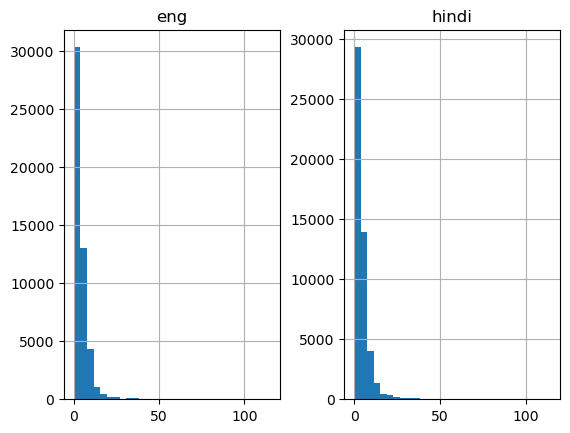

In [5]:
##################  Popualte the lsit with sentence lengths

hindi_sent_length_list=[  (len(sent.split()))  for sent in lines['hindi'] ]
eng_sent_length_list=[  (len(sent.split()))  for sent in lines['eng'] ]

length_df = pd.DataFrame({'eng':eng_sent_length_list, 'hindi':hindi_sent_length_list})
length_df.hist(bins = 30)
plt.show()

## (Tokenize) Convert each sentence to list of integers

In [6]:

############ Function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
############ Function to build a tokenizer    

In [7]:
################ Create english tokenizer
eng_tokenizer = tokenization(lines['eng'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)
################ Create english tokenizer

################ Create hindi tokenizer
hindi_tokenizer = tokenization(lines['hindi'])
hindi_vocab_size = len(hindi_tokenizer.word_index) + 1
hindi_length = 8
print('Hindi Vocabulary Size: %d' % hindi_vocab_size)
################ Create hindi tokenizer


## To print eng dictionary
# eng_tokenizer.word_index

## To print hindi dictionary
# hindi_tokenizer.word_index

English Vocabulary Size: 3706
Hindi Vocabulary Size: 4953


### Encode amd Pad Sentences

In [8]:

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Create 2D list where first element is hindi and second element is english

In [9]:
hindi_eng=lines[['hindi','eng']].to_numpy()
hindi_eng[:5]  #.shape

array([['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
        'give your application an accessibility workout'],
       ['एक्सेर्साइसर पहुंचनीयता अन्वेषक',
        'accerciser accessibility explorer'],
       ['निचले पटल के लिए डिफोल्ट प्लगइन खाका',
        'the default plugin layout for the bottom panel'],
       ['ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका',
        'the default plugin layout for the top panel'],
       ['उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है',
        'a list of plugins that are disabled by default']], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(hindi_eng, test_size=0.2, random_state = 12)

In [11]:
train.shape

(40000, 2)

## Prepare Training and Validation Data

In [12]:
############# Training Data 
trainX= encode_sequences(hindi_tokenizer, hindi_length,train[:,0] )
trainY= encode_sequences(eng_tokenizer, eng_length, train[:,1])
############# Validation Data 
testX= encode_sequences(hindi_tokenizer, hindi_length,test[:,0] )
testY= encode_sequences(eng_tokenizer, eng_length, test[:,1])


### Define the Model

In [13]:
######## Build NMT model
def create_model(source_vocab_size, target_vocab_size, source_timesteps, target_timesteps, units):
    model= Sequential()
    model.add(Embedding(source_vocab_size,units, input_length=source_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(target_timesteps))
    model.add(LSTM(units, return_sequences=True ))
    model.add(Dense(target_vocab_size, activation='softmax'))
    return model


In [14]:
# model compilation
model = create_model(hindi_vocab_size, eng_vocab_size, hindi_length, eng_length, 512)

In [15]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

## Fit the Model

In [16]:
trainX.shape

(40000, 8)

In [17]:
filename = 'model.h1.6_nov_22'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

########## Train the Model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30


2022-11-06 16:43:16.660841: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - ETA: 0s - loss: 3.6450
Epoch 1: val_loss improved from inf to 3.08368, saving model to model.h1.6_nov_22


2022-11-06 16:44:05.609285: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 52s 767ms/step - loss: 3.6450 - val_loss: 3.0837
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 3.0489
Epoch 2: val_loss improved from 3.08368 to 2.92896, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 58s 922ms/step - loss: 3.0489 - val_loss: 2.9290
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.9093
Epoch 3: val_loss improved from 2.92896 to 2.85396, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 56s 886ms/step - loss: 2.9093 - val_loss: 2.8540
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.7850
Epoch 4: val_loss improved from 2.85396 to 2.72243, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 57s 908ms/step - loss: 2.7850 - val_loss: 2.7224
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.6353
Epoch 5: val_loss improved from 2.72243 to 2.60746, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 63s 998ms/step - loss: 2.6353 - val_loss: 2.6075
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.4934
Epoch 6: val_loss improved from 2.60746 to 2.50437, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 64s 1s/step - loss: 2.4934 - val_loss: 2.5044
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 2.3544
Epoch 7: val_loss improved from 2.50437 to 2.30505, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 72s 1s/step - loss: 2.3544 - val_loss: 2.3050
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 2.2137
Epoch 8: val_loss improved from 2.30505 to 2.22302, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 79s 1s/step - loss: 2.2137 - val_loss: 2.2230
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 2.0648
Epoch 9: val_loss improved from 2.22302 to 2.07737, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 82s 1s/step - loss: 2.0648 - val_loss: 2.0774
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.9098
Epoch 10: val_loss improved from 2.07737 to 1.92564, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 97s 2s/step - loss: 1.9098 - val_loss: 1.9256
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.7497
Epoch 11: val_loss improved from 1.92564 to 1.79536, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 97s 2s/step - loss: 1.7497 - val_loss: 1.7954
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.5980
Epoch 12: val_loss improved from 1.79536 to 1.64920, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 93s 1s/step - loss: 1.5980 - val_loss: 1.6492
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.4451
Epoch 13: val_loss improved from 1.64920 to 1.49602, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 95s 2s/step - loss: 1.4451 - val_loss: 1.4960
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.2976
Epoch 14: val_loss improved from 1.49602 to 1.38181, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 93s 1s/step - loss: 1.2976 - val_loss: 1.3818
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.1649
Epoch 15: val_loss improved from 1.38181 to 1.25826, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 95s 2s/step - loss: 1.1649 - val_loss: 1.2583
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.0412
Epoch 16: val_loss improved from 1.25826 to 1.16616, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 95s 2s/step - loss: 1.0412 - val_loss: 1.1662
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 0.9273
Epoch 17: val_loss improved from 1.16616 to 1.08403, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 92s 1s/step - loss: 0.9273 - val_loss: 1.0840
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.8257
Epoch 18: val_loss improved from 1.08403 to 0.97280, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 94s 1s/step - loss: 0.8257 - val_loss: 0.9728
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.7324
Epoch 19: val_loss improved from 0.97280 to 0.91908, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 100s 2s/step - loss: 0.7324 - val_loss: 0.9191
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.6540
Epoch 20: val_loss improved from 0.91908 to 0.81136, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 99s 2s/step - loss: 0.6540 - val_loss: 0.8114
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.5761
Epoch 21: val_loss improved from 0.81136 to 0.76499, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 96s 2s/step - loss: 0.5761 - val_loss: 0.7650
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.5121
Epoch 22: val_loss improved from 0.76499 to 0.69645, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 79s 1s/step - loss: 0.5121 - val_loss: 0.6965
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.4552
Epoch 23: val_loss improved from 0.69645 to 0.62871, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 66s 1s/step - loss: 0.4552 - val_loss: 0.6287
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.4060
Epoch 24: val_loss improved from 0.62871 to 0.59106, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 65s 1s/step - loss: 0.4060 - val_loss: 0.5911
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.3584
Epoch 25: val_loss improved from 0.59106 to 0.56198, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 71s 1s/step - loss: 0.3584 - val_loss: 0.5620
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.3251
Epoch 26: val_loss improved from 0.56198 to 0.51684, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 80s 1s/step - loss: 0.3251 - val_loss: 0.5168
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.2899
Epoch 27: val_loss improved from 0.51684 to 0.48950, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 79s 1s/step - loss: 0.2899 - val_loss: 0.4895
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.2655
Epoch 28: val_loss improved from 0.48950 to 0.46441, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 83s 1s/step - loss: 0.2655 - val_loss: 0.4644
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.2388
Epoch 29: val_loss improved from 0.46441 to 0.44274, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 88s 1s/step - loss: 0.2388 - val_loss: 0.4427
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.2194
Epoch 30: val_loss improved from 0.44274 to 0.42990, saving model to model.h1.6_nov_22


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


INFO:tensorflow:Assets written to: model.h1.6_nov_22/assets


63/63 [==============================] - 91s 1s/step - loss: 0.2194 - val_loss: 0.4299


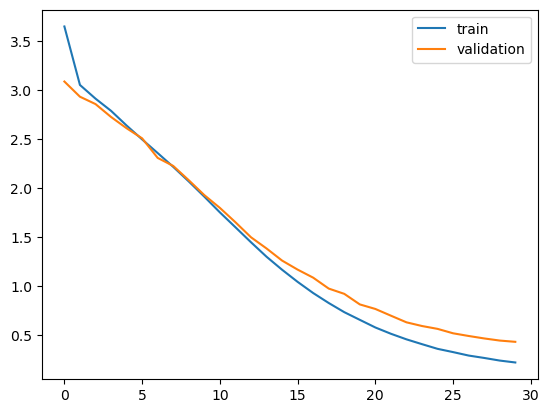

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

## Prediction on Unseen Data

In [19]:
import numpy as np
model = load_model(filename)

temp=model.predict(testX.reshape((testX.shape[0],testX.shape[1]))) 
preds=np.argmax(temp,axis=1)



2022-11-06 17:23:49.623373: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-06 17:23:51.959963: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-06 17:23:52.386990: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-06 17:23:52.396252: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-11-06 17:23:52.525886: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

In [20]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [21]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [22]:
temp = np.array(preds_text)
len(temp[0])

6944

In [23]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [24]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,video dvd could not be opened,project of the the of a to the the s the file of the the the to the to the file of the s file the s the file to the s the file to the ...
1,translator credits,s project a to file project file project the project file project a the to a project a to project to a project the to project to project project the file a to a the to the pro...
2,next document,s file to a the to the project the s a the to the the the to the the to the the project the the to to the the the project a the to to the ...
3,unknown notification,project to the to to the to the to the the to the to to to the to to to to to to the to the to the of to to to the to to the to to ...
4,the scrolling direction,s the the s to the to to to to file to the the to project to the to the file to of the to the to the to the to ...
5,natural height set,project the to the a to to of the to of the to the of the the the to the a the the the to the to the to to the the to the to the to the a the to the the of t...
6,control style,file the file the the the the the the the the the the project the the the the a the the the the the a the the a the to the the the ...
7,vertical repeat,s the to the project the the the the the the the the the the the the the the the the the the the the the ...
8,apply selected stash,project the to the to of to to the to the to to the to to the the to to to the to the to to the the to the to to the to the to the to to the to to of the to...
9,x start scale,s the the project the project the the the to the to to the to the project the the to the project to the the project the the to to the to the to to fi...


In [27]:
pred_df['predicted'][0]

'project  of  the    the  of a to  the  the  s  the       file   of             the  the  the to  the  to   the file  of the s     file  the    s  the  file  to  the   s  the   file   to the          the   the   to    the   the  s  the   file     the      s    s  the    the     s  the  to      the s       file    the file the  the  to the  s   to   the    the   s      the  the     the    s the  s of file  file s the s    the   the     the    s file  the  file s    s  the  the  file s  the   the file   the  the file s     the    the   the     s  s  s file s the  file  the  the  file s     the   the   s   the file the   s  the  the   the      the to s  to the  s the   s   the   s file the   the     s the  s the s    the  s       s  the    s     the file the   s     the s  the  s the   s the   to the     the file s   file  the s  the    the   file  file the   to  s    file   the s  the     file  s    the s    the  the   file the   s   s  to the file  s file the   s the   to     the  s the